# KPMG- Assessment

## Hotels Analysis

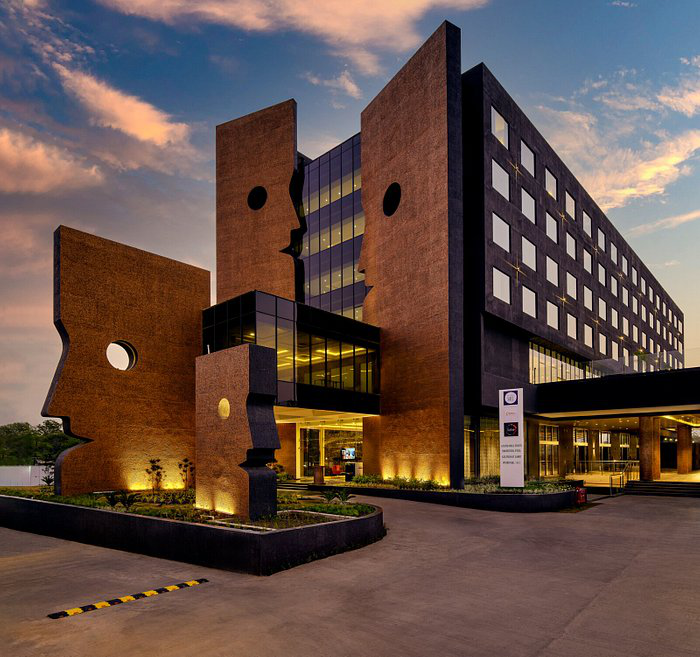

In [1]:
from IPython.display import display
from PIL import Image


path="/kaggle/input/hotel-image/essentia-luxury-hotel.jpg"
display(Image.open(path))

### Part 1

    Import libraries

In [2]:
import numpy as np
import pandas as pd

#### 1. Load the data

In [3]:
data = pd.read_csv("/kaggle/input/kpmghotels/hotels.csv")

    Clean the data

In [4]:
data["days_since_review"] = data["days_since_review"].str.replace(" days","")
data["days_since_review"] = data["days_since_review"].str.replace(" day","")
data["days_since_review"] = pd.to_numeric(data["days_since_review"])

    Summarise the data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   review_date                                 515738 non-null  object 
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   positive_review                             515738 non-null  object 
 5   reviewer_score                              515738 non-null  float64
 6   tags                                        515738 non-null  object 
 7   days_since_review                           515738 non-null  int64  
 8   reviewer_nationality                        515738 non-null  object 
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

#### 2. Preparing plots for the followings:

    1.  Top 10 hotels based on number of reviews

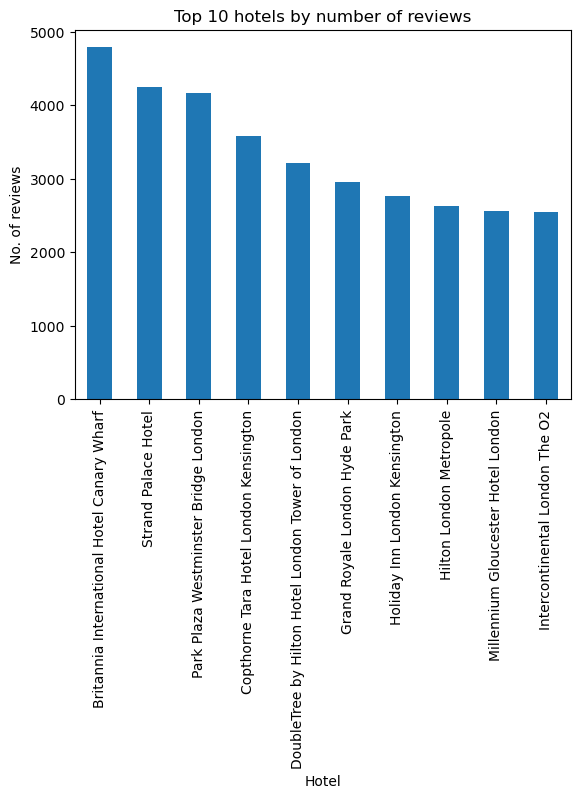

In [6]:
import matplotlib.pyplot as plt

top_10_reviews = data.groupby(["hotel_name"])["hotel_name"].count().sort_values(ascending = False)[0:10]
top_10_reviews.plot(kind = "bar")
plt.xlabel("Hotel")
plt.ylabel("No. of reviews")
plt.title("Top 10 hotels by number of reviews")
plt.show()

    2.  Top 10 least reliable hotels measured using the interquartile range of review scores

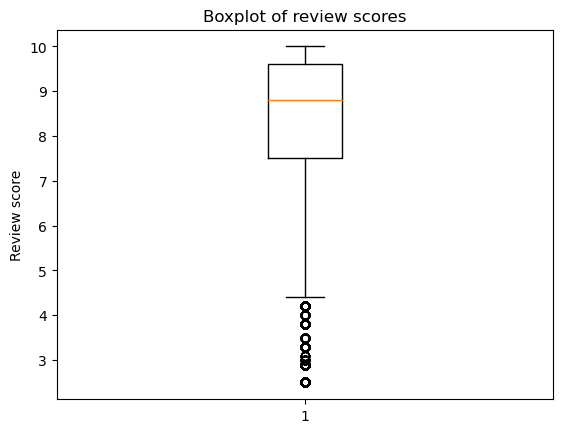

In [7]:
plt.boxplot(data["reviewer_score"]);
plt.ylabel("Review score")
plt.title("Boxplot of review scores")
plt.show()

    Calculate the interquartile range for reviewer_score

In [8]:
lower = np.percentile(data["reviewer_score"],2.5)
upper = np.percentile(data["reviewer_score"],97.5)
iqr_review_score_data = data[(data["reviewer_score"] > lower) & (data["reviewer_score"] < upper)]

    Filter 10 least reliable hotels measured by interquartile of reviewer_score

In [9]:
top_10_least_review_score = iqr_review_score_data.sort_values(by = "reviewer_score")[0:10]
top_10_least_review_score[["hotel_name","reviewer_score"]].reset_index(drop = True)

,hotel_name,reviewer_score
0,Holiday Inn London West,4.4
1,Shepherd s Bush Boutique Hotel,4.4
2,Occidental Atenea Mar Adults Only,4.4
3,Holiday Inn London Kensington,4.4
4,Park Grand Paddington Court,4.4
5,Amarante Champs Elys es,4.4
6,Majestic Hotel Spa Barcelona GL,4.4
7,Good Hotel London,4.4
8,Melia Vienna,4.4
9,The Chelsea Harbour Hotel,4.4


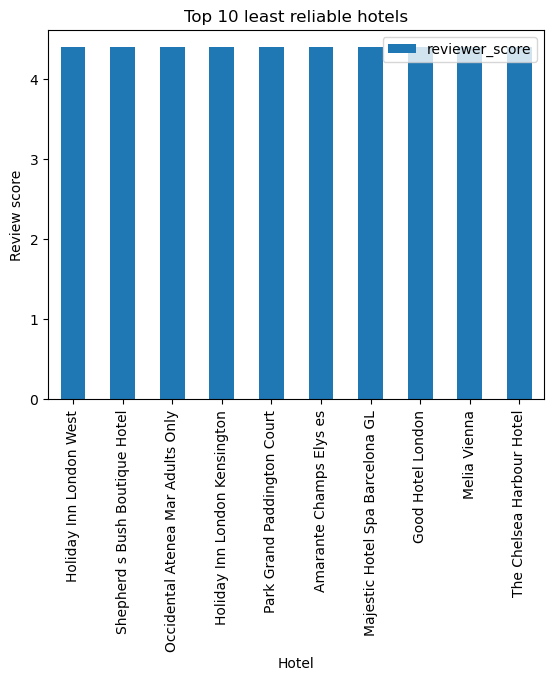

In [10]:
top_10_least_review_score.plot(x = "hotel_name", y = "reviewer_score", kind= "bar")
plt.xlabel("Hotel")
plt.ylabel("Review score")
plt.title("Top 10 least reliable hotels")
plt.show()

#### 3. New Column positive_review_wc

In [11]:
data['positive_review_wc'] = data['positive_review'].str.split().str.len()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   review_date                                 515738 non-null  object 
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   positive_review                             515738 non-null  object 
 5   reviewer_score                              515738 non-null  float64
 6   tags                                        515738 non-null  object 
 7   days_since_review                           515738 non-null  int64  
 8   reviewer_nationality                        515738 non-null  object 
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

#### 4. The scatterplot of reviewer_score and positive_review_wc

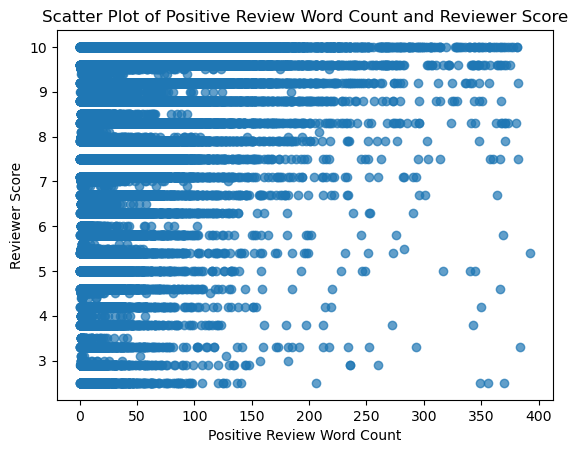

The correlation between reviewer_score and positive_review_wc 0.211


In [12]:
plt.scatter(data['positive_review_wc'], data['reviewer_score'],alpha=0.7)
plt.title("Scatter Plot of Positive Review Word Count and Reviewer Score")
plt.xlabel("Positive Review Word Count")
plt.ylabel("Reviewer Score")
plt.show()
print("The correlation between reviewer_score and positive_review_wc", round(data['reviewer_score'].corr(data['positive_review_wc']),3))

From the scatter plot and also from the correlation, it can be confirmed that there is a slightly positive relationship between positive_review_wc and reviewer_score. As the number of positive review word count increases, the reviewer score tends to increase as well. However, the relationship is not very strong, as there are still many reviews with a low score despite having a relatively high word count of positive words.

#### 5. Find 10 most frequently used words in 'positive_review'

    Step 1: Identify stopwords

In [13]:
from nltk.corpus import stopwords
init_stop = stopwords.words('english')
new_stopwords = ["a", "an", "the", "i", "you", "we", "they"]
for i in new_stopwords:
    init_stop.append(i)
pat = r'\b(?:{})\b'.format('|'.join(init_stop))

    Step 2: Remove stopwords

In [14]:
data['positive_review']= data['positive_review'].str.lower().str.replace(pat, '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


    Step 3: Find 10 most frequently used words from the positive_review

In [15]:
data['positive_review'].str.split().explode().value_counts().head(10)

staff        194574
location     192856
room         140746
hotel        125326
good         112321
great        105641
friendly      85353
breakfast     84581
helpful       76183
nice          69449
Name: positive_review, dtype: int64

### Part 2: Fit classification models on the data provided to predict whether the reviewer_score is greater than nine.

In [16]:
# Create negative_review_wc that counts number of words in negative_review column
data['negative_review_wc'] = data['negative_review'].str.split().str.len()

    Step 1: Plot the correlation matrix to identify the potential relevant features

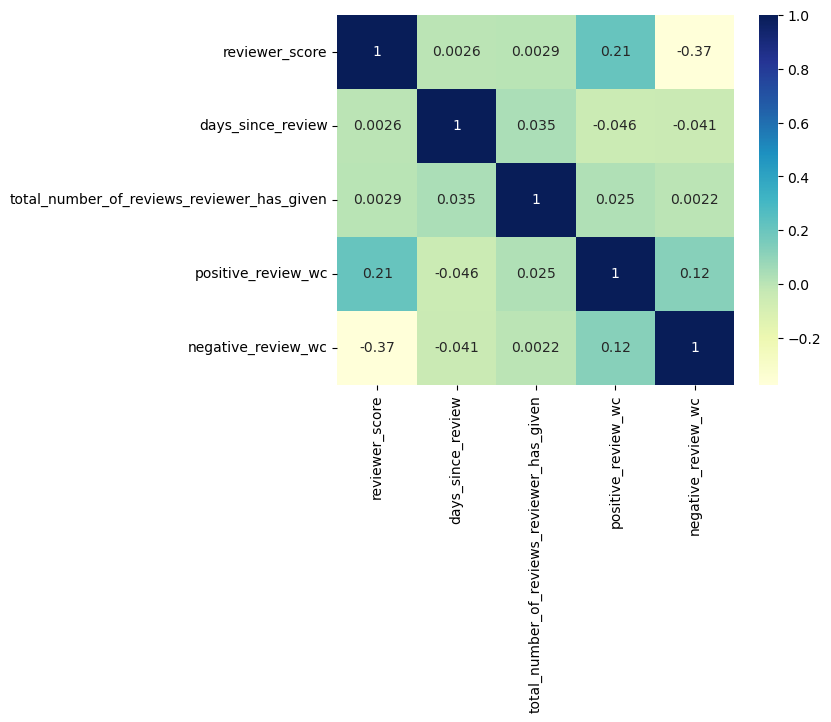

In [17]:
import seaborn as sb


dataplot = sb.heatmap(data.drop(['lat','lng'],axis =1).corr(), cmap="YlGnBu", annot=True)

    Step 2: Fit the models on the first features that have high correlation

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# create a binary target variable indicating whether reviewer_score is greater than 9
data['high_reviewer_score'] = data['reviewer_score'].apply(lambda x: 1 if x > 9 else 0)

# select relevant features for modeling
X = data[['positive_review_wc', 'negative_review_wc']]
y = data['high_reviewer_score']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Define the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name}:')
    print(f'Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}')

Decision Tree:
Accuracy: 0.711, Precision: 0.696, Recall: 0.704, F1 Score: 0.700
Random Forest:
Accuracy: 0.712, Precision: 0.694, Recall: 0.710, F1 Score: 0.702


The Decision Tree and Random Forest models both have high accuracy, precision, recall, and F1 scores. This suggests that they are both effective models for the classification. The performance of the two models is very similar, with only slight differences in precision and recall. Therefore, either model could be used to fit classification models on the data provided to predict whether the reviewer_score is greater than nine.

    Step 3: Try on more features

In [19]:
# select more relevant features for modeling
X_2 = data[[ 'days_since_review', 'total_number_of_reviews_reviewer_has_given', 'positive_review_wc', 'negative_review_wc']]
y_2 = data['high_reviewer_score']

# split the data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=123)

# Define the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train_2, y_train_2)
    y_pred_2 = model.predict(X_test_2)
    acc_2 = accuracy_score(y_test_2, y_pred_2)
    prec_2 = precision_score(y_test_2, y_pred_2)
    rec_2 = recall_score(y_test_2, y_pred_2)
    f1_2 = f1_score(y_test_2, y_pred_2)
    print(f'{name}:')
    print(f'Accuracy: {acc_2:.3f}, Precision: {prec_2:.3f}, Recall: {rec_2:.3f}, F1 Score: {f1_2:.3f}')


Decision Tree:
Accuracy: 0.620, Precision: 0.605, Recall: 0.592, F1 Score: 0.599
Random Forest:
Accuracy: 0.666, Precision: 0.655, Recall: 0.640, F1 Score: 0.647


    Step 4: Conclusion

The set of results (Decision Tree: Accuracy: 0.620, Precision: 0.605, Recall: 0.592, F1 Score: 0.598; Random Forest: Accuracy: 0.667, Precision: 0.655, Recall: 0.640, F1 Score: 0.647) indicates a decrease in the models' performance. Therefore, we should not include 'days_since_review' and 'total_number_of_reviews_reviewer_has_given' features in our models